In [5]:
import pandas as pd
import math
import numpy as np
import scipy
import time
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.stats import binom, hypergeom
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


import matplotlib.pyplot as plt
import copy
%matplotlib inline

%matplotlib inline

## I. Data cleaning and feature engineering

### 1. Import dataset downloaded from Kaggle and create time-related features

In [8]:
df = pd.read_csv('data/cab_rides.csv')

In [9]:
df['day']=df.time_stamp.apply(lambda x: time.strftime('%a', time.localtime(x/1000)))


In [10]:
df['AMPM']=df.time_stamp.apply(lambda x: time.strftime('%p', time.localtime(x/1000)))


In [11]:
df['month']=df.time_stamp.apply(lambda x: time.strftime('%b', time.localtime(x/1000)))


In [12]:
df['time']=df.time_stamp.apply(lambda x: time.strftime('%H', time.localtime(x/1000)))


In [13]:
df['week']=df.time_stamp.apply(lambda x: time.strftime('%U', time.localtime(x/1000)))


In [14]:
df['date_time']=df.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x/1000)))


### 2. Create variable as key for merging with a weather data set

In [15]:
df['merge_date'] = df.source.astype(str) +" - "+ df.date_time.astype("str") 

In [16]:
df1 = pd.read_csv('data/weather.csv')

In [17]:
df1['date_time']=df1.time_stamp.apply(lambda x: time.strftime('%Y-%m-%d %H', time.localtime(x)))

In [18]:
#create a variable with time and location for merging
df1['merge_date'] = df1.location.astype(str) +" - "+ df1.date_time.astype("str") 

In [19]:
merged_df = df.merge(df1, how='inner', left_on = ['merge_date'], right_on=['merge_date'], suffixes=('_c','_w'))
merged_df.head()

,distance,cab_type,time_stamp_c,destination,source,price,surge_multiplier,id,product_id,name,...,merge_date,temp,location,clouds,pressure,rain,time_stamp_w,humidity,wind,date_time_w
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
1,1.33,Lyft,1544952309308,Beacon Hill,Haymarket Square,7.0,1.0,0d468502-34b5-447f-be9f-acbb62176072,lyft,Lyft,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
2,0.53,Lyft,1544951109578,North Station,Haymarket Square,27.5,1.0,2aa8d17e-4b13-4200-87db-db3eed73ca6b,lyft_luxsuv,Lux Black XL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
3,2.36,Lyft,1544954108860,Back Bay,Haymarket Square,7.0,1.0,4944c164-0463-47b9-96e1-15ffe8b9c7c9,lyft_line,Shared,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04
4,0.62,Uber,1544954108161,West End,Haymarket Square,10.5,1.0,b1c23003-39fb-4030-9961-4f3420b23907,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,Haymarket Square - 2018-12-16 04,38.46,Haymarket Square,0.29,1022.25,NaN,1544953501,0.76,7.68,2018-12-16 04


### 3. Further cleaning of the merged dataframe and create additional features that might have predictive power

In [20]:
# drop duplicates
merged_df.drop_duplicates(subset='id', keep='first', inplace=True)

In [121]:
merged_df['time'] = merged_df['time'].astype(int)

In [122]:
merged_df['rushhr'] = 0

In [123]:
merged_df.loc[(merged_df.time > 7) & (merged_df.time < 10), 'rushhr'] = 1

In [124]:
merged_df.loc[(merged_df.time > 17) & (merged_df.time < 22), 'rushhr'] = 1

In [126]:
#one hot encoding all the categorical variables
merged_df = pd.get_dummies(merged_df, columns=[
                           'cab_type', 'destination', 'source', 'name', 'day', 'AMPM', 'month', 'week'])

In [176]:
merged_df['wkndPM']=0

In [177]:
merged_df.loc[(merged_df.day_Fri == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sat == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1
merged_df.loc[(merged_df.day_Sun == 1) & (merged_df.AMPM_PM == 1), 'wkndPM'] = 1

In [179]:
wkndPMdf = merged_df.groupby('merge_date')['wkndPM'].sum()
with pd.option_context("display.max_rows", 1000):
    display(wkndPMdf)

merge_date
Back Bay - 2018-11-25 22              8
Back Bay - 2018-11-25 23             23
Back Bay - 2018-11-26 00              0
Back Bay - 2018-11-26 01              0
Back Bay - 2018-11-26 02              0
Back Bay - 2018-11-26 03              0
Back Bay - 2018-11-26 04              0
Back Bay - 2018-11-26 05              0
Back Bay - 2018-11-26 06              0
Back Bay - 2018-11-26 07              0
Back Bay - 2018-11-26 08              0
Back Bay - 2018-11-26 09              0
Back Bay - 2018-11-26 10              0
Back Bay - 2018-11-26 11              0
Back Bay - 2018-11-26 12              0
Back Bay - 2018-11-26 13              0
Back Bay - 2018-11-26 14              0
Back Bay - 2018-11-26 15              0
Back Bay - 2018-11-26 16              0
Back Bay - 2018-11-26 17              0
Back Bay - 2018-11-26 18              0
Back Bay - 2018-11-26 19              0
Back Bay - 2018-11-26 20              0
Back Bay - 2018-11-26 21              0
Back Bay - 2018-11-26 22     

In [128]:
merged_df['Black'] = 0

In [129]:
merged_df['Black'] = merged_df['name_Black'] + merged_df['name_Black SUV'] + \
    merged_df['name_Lux Black'] + merged_df['name_Lux Black XL']

In [130]:
merged_df.groupby('Black')['name_Black','name_Black SUV','name_Lux Black','name_Lux Black XL'].sum()

,name_Black,name_Black SUV,name_Lux Black,name_Lux Black XL
Black,,,,
0,0.0,0.0,0.0,0.0
1,54852.0,54849.0,51021.0,51019.0


In [22]:
merged_df['base_price'] = merged_df.price/merged_df.surge_multiplier

In [131]:
merged_df['sports'] = 0

In [132]:
#A sport event dummy that equals 1 when a major sport team in the city has a game that day (Patriots, Celtics, Bruins)
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-02')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-30')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-06')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-10')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-14')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-11-29')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-01')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-08')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-11')) & (merged_df.AMPM_PM == 1), 'sports'] = 1
merged_df.loc[(merged_df.date_time_c.str.contains('2018-12-16')) & (merged_df.AMPM_PM == 1), 'sports'] = 1

In [137]:
sportdf = merged_df.groupby('date_time_c')['sports'].sum()
with pd.option_context("display.max_rows", 1000):
    display(sportdf)

date_time_c
2018-11-25 22       0
2018-11-25 23       0
2018-11-26 00       0
2018-11-26 01       0
2018-11-26 02       0
2018-11-26 03       0
2018-11-26 04       0
2018-11-26 05       0
2018-11-26 06       0
2018-11-26 07       0
2018-11-26 08       0
2018-11-26 09       0
2018-11-26 10       0
2018-11-26 11       0
2018-11-26 12       0
2018-11-26 13       0
2018-11-26 14       0
2018-11-26 15       0
2018-11-26 16       0
2018-11-26 17       0
2018-11-26 18       0
2018-11-26 19       0
2018-11-26 20       0
2018-11-26 21       0
2018-11-26 22       0
2018-11-26 23       0
2018-11-27 00       0
2018-11-27 01       0
2018-11-27 02       0
2018-11-27 03       0
2018-11-27 04       0
2018-11-27 05       0
2018-11-27 06       0
2018-11-27 07       0
2018-11-27 08       0
2018-11-27 09       0
2018-11-27 10       0
2018-11-27 11       0
2018-11-27 12       0
2018-11-27 13       0
2018-11-27 14       0
2018-11-27 15       0
2018-11-27 16       0
2018-11-27 17       0
2018-11-27 18       

In [23]:
# log-transforming all numerical variables
names = ['distance', 'price', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind', 'base_price', 'surge_multiplier']
for n in names:
    merged_df[f'l{n}'] = np.log(merged_df[n])

/Users/ptw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


### 4. Drop rows with nan values and clean the nan values in the rain variable

In [140]:
merged_df.rain.fillna(0, inplace= True)

In [141]:
merged_df['rain_d']=0

In [142]:
merged_df.loc[(merged_df.rain) > 0, 'rain_d'] = 1


In [144]:
merged_df[merged_df.rain_d == 0].count()

distance                               591351
time_stamp_c                           591351
price                                  544454
surge_multiplier                       591351
id                                     591351
product_id                             591351
date_time_c                            591351
time                                   591351
merge_date                             591351
temp                                   591351
location                               591351
clouds                                 591351
pressure                               591351
rain                                   591351
time_stamp_w                           591351
humidity                               591351
wind                                   591351
date_time_w                            591351
rushhr                                 591351
cab_type_Lyft                          591351
cab_type_Uber                          591351
destination_Back Bay              

In [145]:
merged_df.dropna(inplace=True)

In [156]:
merged_df.drop(['time_stamp_c', 'time_stamp_w', 'date_time_c',
                'date_time_w', 'id', 'product_id'], axis=1, inplace=True)

In [445]:
merged_df.drop(['lrain', 'lclouds'], axis=1, inplace=True)

In [439]:
# save cleaned dataset locally
merged_df.to_csv('data/merged_df_Tues.csv')

## II. Visualization

### 1. Visually inspect each feature to identify non-normal distributions, collinearity, etc.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8c2bc2240>,
      dtype=object)

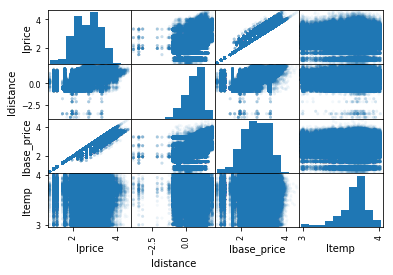

In [313]:
pd.plotting.scatter_matrix(merged_df[['lprice',
       'ldistance','lbase_price','ltemp']], alpha=.05)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8805470f0>,
      dtype=object)

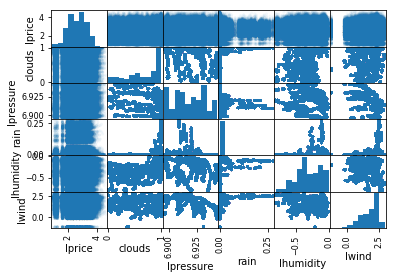

In [315]:
pd.plotting.scatter_matrix(merged_df[['lprice', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind']], alpha = .05)

In [81]:
merged_df.corr()

,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,cab_type_Lyft,...,name_Lux Black,name_Lux Black XL,name_Lyft,name_Lyft XL,name_Shared,name_Taxi,name_UberPool,name_UberX,name_UberXL,name_WAV
distance,1.000000,0.345082,0.025830,-0.003099,0.000342,0.003708,0.000789,-0.003740,-0.004251,-1.929998e-03,...,-0.000515,-0.000622,-0.000651,-0.000569,-0.000642,NaN,6.052217e-04,0.000524,0.000574,0.000577
price,0.345082,1.000000,0.240325,0.000005,0.001290,0.001012,0.000710,-0.001704,-0.001185,8.344084e-02,...,0.206547,0.500083,-0.219748,-0.039171,-0.333225,NaN,-2.569535e-01,-0.223527,-0.028578,-0.223570
surge_multiplier,0.025830,0.240325,1.000000,-0.001635,-0.001996,-0.002912,-0.001067,-0.001253,0.001286,1.637199e-01,...,0.068319,0.068519,0.071222,0.071166,-0.046650,NaN,-4.854270e-02,-0.048536,-0.048546,-0.048542
temp,-0.003099,0.000005,-0.001635,1.000000,0.437995,-0.377918,0.133400,0.366563,0.120664,1.926454e-03,...,-0.000582,0.001017,0.001175,0.001217,0.000318,NaN,-2.453412e-04,-0.002278,-0.001497,-0.000410
clouds,0.000342,0.001290,-0.001996,0.437995,1.000000,-0.210674,0.210941,0.509777,0.125876,-1.838530e-03,...,-0.001767,0.000983,-0.001790,0.001140,-0.000657,NaN,-9.199194e-04,0.000712,-0.000824,0.000376
pressure,0.003708,0.001012,-0.002912,-0.377918,-0.210674,1.000000,-0.069215,-0.132083,-0.569770,4.943372e-04,...,0.001093,0.001252,0.000350,-0.001506,-0.000845,NaN,1.021110e-04,0.000750,-0.000481,-0.000594
rain,0.000789,0.000710,-0.001067,0.133400,0.210941,-0.069215,1.000000,0.209892,0.218114,-3.075045e-03,...,-0.000867,-0.001492,-0.001808,-0.000359,-0.001892,NaN,1.424031e-03,0.000343,0.000167,-0.000426
humidity,-0.003740,-0.001704,-0.001253,0.366563,0.509777,-0.132083,0.209892,1.000000,-0.208435,-1.611857e-03,...,-0.000856,-0.000467,-0.001110,0.000948,-0.000815,NaN,3.347317e-04,0.000439,0.000012,0.000126
wind,-0.004251,-0.001185,0.001286,0.120664,0.125876,-0.569770,0.218114,-0.208435,1.000000,-4.234275e-03,...,-0.001954,-0.001899,-0.002297,0.000827,0.000135,NaN,1.390014e-03,0.001637,0.000142,0.000997
cab_type_Lyft,-0.001930,0.083441,0.163720,0.001926,-0.001839,0.000494,-0.003075,-0.001612,-0.004234,1.000000e+00,...,0.306438,0.306432,0.306396,0.306419,0.306386,NaN,-2.964984e-01,-0.296457,-0.296519,-0.296492


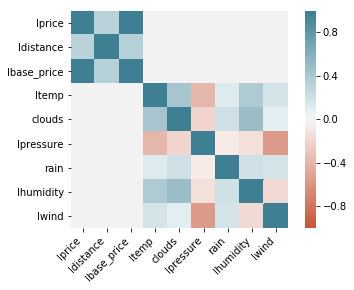

In [316]:
corr = merged_df[['lprice', 'ldistance','lbase_price','ltemp','clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## III. Linear Regression w/ OLS

### 1. Spec 1: logged numerical and all raw one hot encoded dummies (excluding one from each category to avoid collinearity

### a. Fit with a plain OLS

In [469]:
X = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 'cab_type_Uber', 'destination_Back Bay',
       'destination_Boston University',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM']]
X = sm.add_constant(X)
Y = merged_df['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [478]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X,Y, test_size = .2, random_state=42)

In [483]:
model = sm.OLS(Y_train1, X_train1).fit()

In [484]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.340e+05
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:07:17   Log-Likelihood:             2.5351e+05
No. Observations:              508193   AIC:                        -5.069e+05
Df Residuals:                  508139   BIC:                        -5.063e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.1071      0.311      6.774      0.000       1.497       2.717
ldistance                               0.3228      0.000    710.773      0.000       0.322       0.324
ltemp                                   0.0003      0.002      0.157      0.875      -0.004       0.005
clouds                                 -0.0017      0.001     -1.902      0.057      -0.003    5.13e-05
lpressure                              -0.0340      0.055     -0.622      0.534      -0.141       0.073
rain                                    0.0009      0.009      0.103      0.918      -0.017       0.018
lhumidity                              -0.0040      0.002     -1.946      0.052      -0.008    2.85e-05
lwind                                   0.0001      0.001      0.229      0.819      -0.001       0.001
lsurge_multiplier                       0.9409      0.003    318.443      0.000       0.935       0.947
cab_type_Uber                          -0.0374      0.044     -0.843      0.399      -0.125       0.050
destination_Back Bay                    0.0070      0.001      6.913      0.000       0.005       0.009
destination_Boston University           0.1823      0.026      7.029      0.000       0.131       0.233
destination_Fenway                      0.1525      0.026      5.880      0.000       0.102       0.203
destination_Financial District          0.0801      0.001     79.549      0.000       0.078       0.082
destination_Haymarket Square            0.1660      0.026      6.400      0.000       0.115       0.217
destination_North End                   0.1430      0.026      5.511      0.000       0.092       0.194
destination_North Station               0.0496      0.001     48.779      0.000       0.048       0.052
destination_Northeastern University     0.1724      0.026      6.649      0.000       0.122       0.223
destination_South Station               0.1893      0.026      7.300      0.000       0.138       0.240
destination_Theatre District            0.0272      0.001     26.862      0.000       0.025       0.029
destination_West End                    0.0237      0.001     23.367      0.000       0.022       0.026
source_Back Bay                         0.0286      0.001     28.243      0.000       0.027       0.031
source_Boston University                0.1737      0.026      6.701      0.000       0.123       0.225
source_Fenway                           0.1751      0.026      6.754      0.000       0.124       0.226
source_Financial District               0.1063      0.001    105.436      0.000       0.104       0.108
source_Haymarket Square                 0.2049      0.026      7.900      0.000       0.154       0.256
source_North End                        0.1934      0.026      7.45

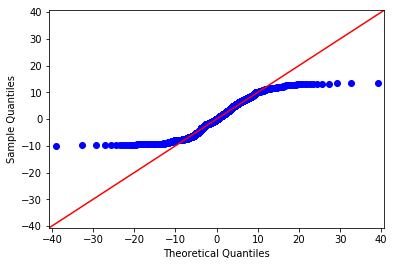

In [485]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line=str(45))
plt.show()

### b. Perform Lasso & Ridge on the spec 1 model

In [486]:
lasso1 = LassoCV()
lasso1.fit(X_train1, Y_train1)
preds1 = lasso1.predict(X_test)
lasso1.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.21006758e-01,  0.00000000e+00, -6.66422074e-05,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        9.18988205e-01, -4.01353343e-01,  6.20326658e-04,  8.64865228e-03,
       -1.86119489e-02,  7.37077186e-02, -6.64023187e-03, -2.93497597e-02,
        4.29953481e-02, -0.00000000e+00,  1.41758235e-02,  2.06845136e-02,
        1.71014539e-02,  1.90934467e-02, -0.00000000e+00,  0.00000000e+00,
        9.66546521e-02,  2.64235078e-02,  1.55829966e-02,  3.65465826e-02,
       -8.66900299e-03,  1.17965093e-02,  6.24361201e-02,  2.93248499e-02,
        7.39779732e-01,  1.14410430e+00,  1.47632905e-01,  4.14784108e-01,
        7.66459961e-01, -4.54797975e-01,  0.00000000e+00, -9.26354696e-01,
        0.00000000e+00, -1.09035896e-01, -8.85507704e-04,  4.59527628e-01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.78630802e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [488]:
lasso1.score(X_test1, Y_test1)

0.9333424033441097

In [492]:
lasso1_res = Y_test1 - preds1

In [494]:
mse1 = mean_squared_error(Y_test1, preds1)

In [495]:
np.exp(mse1)

1.0218534684155705

In [496]:
np.exp(Y_test1).mean()

16.54675518894285

In [535]:
np.exp(mse1)/np.exp(Y_test1).mean()

0.061755519843456105

(array([1.0000e+00, 6.0000e+00, 1.1000e+01, 7.0000e+00, 4.8000e+01,
        6.0000e+01, 6.7000e+01, 1.2000e+02, 8.9000e+01, 9.3000e+01,
        2.6600e+02, 2.6000e+02, 1.8200e+02, 1.8600e+02, 5.1600e+02,
        8.4800e+02, 1.4360e+03, 4.0080e+03, 1.0697e+04, 1.5821e+04,
        2.0048e+04, 2.1033e+04, 1.8005e+04, 1.2496e+04, 8.5190e+03,
        4.9980e+03, 2.5830e+03, 1.6410e+03, 8.8000e+02, 4.9300e+02,
        4.3200e+02, 3.0400e+02, 2.6500e+02, 1.8900e+02, 1.0700e+02,
        8.7000e+01, 7.6000e+01, 4.7000e+01, 2.7000e+01, 1.6000e+01,
        1.7000e+01, 6.0000e+00, 1.4000e+01, 1.9000e+01, 4.0000e+00,
        5.0000e+00, 3.0000e+00, 9.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-1.04167955, -0.99336141, -0.94504327, -0.89672513, -0.84840699,
        -0.80008885, -0.75177071, -0.70345257, -0.65513443, -0.60681629,
        -0.55849815, -0.51018001, -0.46186187, -0.41354373, -0.36522559,
        -0.31690745, -0.26858931, -0.22027117, -0.17195303, -0.12363489,
        -0.07531675, -0.02

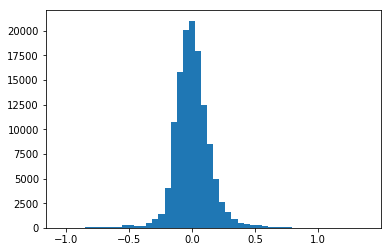

In [498]:
plt.hist(lasso1_res, bins=50)

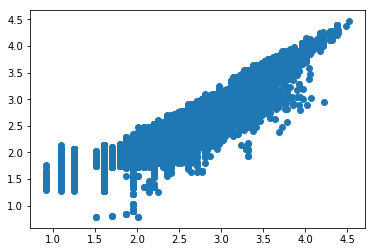

In [499]:
plt.scatter(Y_test1, preds1)

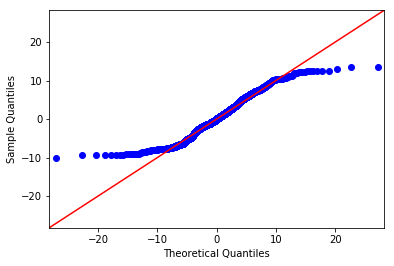

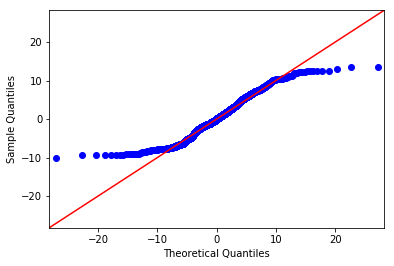

In [500]:
sm.qqplot(lasso1_res, stats.t, fit=True, line=str(45))

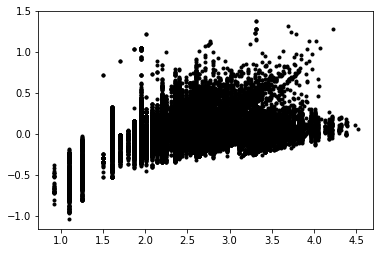

In [504]:
plt.plot(Y_test1, lasso1_res, 'k.')

In [505]:
ridge1 = RidgeCV()
ridge1.fit(X_train1, Y_train1)
preds1r = ridge1.predict(X_test1)
ridge1.coef_

array([ 0.00000000e+00,  3.22816497e-01,  3.94115646e-04, -1.70551042e-03,
       -2.98511272e-02,  8.80919622e-04, -3.91730525e-03,  1.30647722e-04,
        9.40569090e-01, -3.38414547e-01,  6.98434774e-03,  6.72381156e-03,
       -2.30690253e-02,  8.01324647e-02, -9.57725805e-03, -3.26357552e-02,
        4.95690179e-02, -3.14534488e-03,  1.37407449e-02,  2.72450709e-02,
        2.36722629e-02,  2.86084479e-02, -1.84125451e-03, -4.41410103e-04,
        1.06247878e-01,  2.93155499e-02,  1.77951133e-02,  4.63861293e-02,
       -1.04342008e-02,  1.35690292e-02,  7.20591335e-02,  3.91472943e-02,
        7.43527246e-01,  1.14784981e+00,  2.13751894e-01,  4.80916379e-01,
        8.32597948e-01, -3.91372664e-01,  6.47952716e-02, -8.62274282e-01,
        0.00000000e+00, -1.07805027e-01,  3.38847581e-04,  4.63280027e-01,
       -4.18141919e-03, -1.16814113e-03, -2.87788459e-03, -3.88609461e-03,
       -2.37782989e-03, -4.36055009e-03, -1.08950080e-03, -3.03027652e-04,
        1.75383726e-03, -

In [506]:
ridge1.score(X_test1, Y_test1)

0.9333780463535375

In [507]:
ridge1_res = Y_test1 - preds1r

In [508]:
mse1r = mean_squared_error(Y_test1, preds1r)

In [510]:
np.exp(mse1r)

1.0218416562797008

In [511]:
np.exp(Y_test1).mean()

16.54675518894285

In [537]:
np.exp(mse1r)/np.exp(Y_test1).mean()

0.06175480597927339

(array([1.0000e+00, 6.0000e+00, 1.1000e+01, 6.0000e+00, 4.7000e+01,
        5.9000e+01, 5.6000e+01, 1.3000e+02, 8.9000e+01, 8.2000e+01,
        2.6700e+02, 2.6600e+02, 1.8400e+02, 1.7500e+02, 5.1600e+02,
        8.2100e+02, 1.4220e+03, 4.0570e+03, 1.0488e+04, 1.5844e+04,
        2.0284e+04, 2.0883e+04, 1.8181e+04, 1.2499e+04, 8.5050e+03,
        5.0430e+03, 2.5820e+03, 1.5520e+03, 8.6900e+02, 4.8800e+02,
        4.3900e+02, 3.0400e+02, 2.6700e+02, 1.8800e+02, 1.0800e+02,
        8.3000e+01, 7.6000e+01, 4.6000e+01, 3.2000e+01, 1.3000e+01,
        1.3000e+01, 9.0000e+00, 1.4000e+01, 1.9000e+01, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 6.0000e+00, 5.0000e+00, 2.0000e+00]),
 array([-1.04513095, -0.99665875, -0.94818654, -0.89971433, -0.85124213,
        -0.80276992, -0.75429771, -0.70582551, -0.6573533 , -0.60888109,
        -0.56040889, -0.51193668, -0.46346447, -0.41499227, -0.36652006,
        -0.31804785, -0.26957565, -0.22110344, -0.17263123, -0.12415903,
        -0.07568682, -0.02

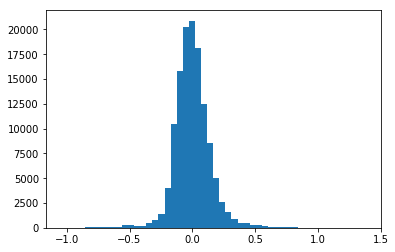

In [538]:
plt.hist(ridge1_res, bins=50)

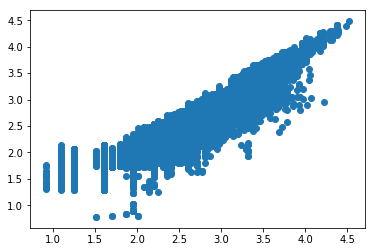

In [514]:
plt.scatter(Y_test1, preds1r)

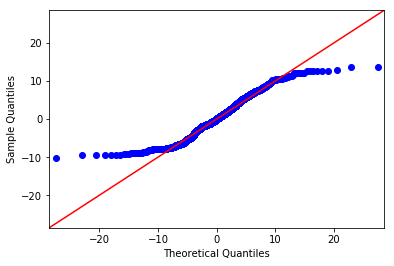

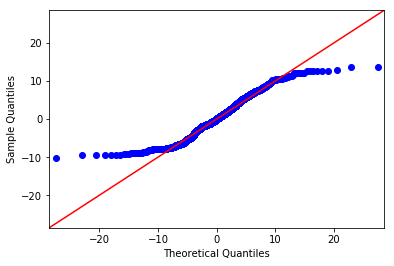

In [515]:
sm.qqplot(ridge1_res, stats.t, fit=True, line=str(45))

### Notes on Spec 1: Both Lasso and Ridge models have low test MSEs, but the QQ plot shows that the residual of this model is non-normal, so we've to keep looking. The QQ plot suggests that some features might have bimodal distribution, so we'll try separating an important feature that is most likely to be binomal: the rides in the "black" categories.

### 2. Spec 2: Separating rides in the "black" categories from the rest, since they're highly correlated with price. 

### Spec2a: rides in the "black" categories
### a. Fit with a plain OLS

In [655]:
X4b = merged_df[(merged_df.Black == 1)][['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d']]
X4b = sm.add_constant(X4b)
Y4b = merged_df[(merged_df.Black == 1)]['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [656]:
X_train4b, X_test4b, Y_train4b, Y_test4b = train_test_split(X4b,Y4b, test_size = .2, random_state=42)

In [661]:
model4b = sm.OLS(Y_train4b, X_train4b).fit()

In [662]:
model4b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     5874.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:45:40   Log-Likelihood:                 17400.
No. Observations:              169392   AIC:                        -3.476e+04
Df Residuals:                  169371   BIC:                        -3.455e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.8689      0.493      5.823      0.000       1.903       3.835
ldistance                               0.2666      0.001    285.085      0.000       0.265       0.268
ltemp                                   0.0059      0.004      1.568      0.117      -0.001       0.013
clouds                                  0.0021      0.002      0.968      0.333      -0.002       0.006
lpressure                               0.0290      0.071      0.411      0.681      -0.109       0.167
rain                                   -0.0129      0.024     -0.532      0.595      -0.060       0.035
lhumidity                              -0.0052      0.004     -1.221      0.222      -0.013       0.003
lwind                                   0.0003      0.001      0.294      0.769      -0.002       0.003
lsurge_multiplier                       0.9886      0.007    140.435      0.000       0.975       1.002
cab_type_Uber                          -0.0478      0.001    -44.174      0.000      -0.050      -0.046
destination_Back Bay                   -0.0511      0.002    -26.221      0.000      -0.055      -0.047
source_Beacon Hill                     -0.0797      0.002    -40.553      0.000      -0.084      -0.076
destination_Haymarket Square            0.0001      0.002      0.062      0.951      -0.004       0.004
destination_Northeastern University     0.0099      0.002      5.021      0.000       0.006       0.014
source_Back Bay                        -0.0556      0.002    -28.335      0.000      -0.059      -0.052
day_Fri                              5.912e-05      0.002      0.030      0.976      -0.004       0.004
AMPM_PM                                -0.0010      0.001     -0.673      0.501      -0.004       0.002
month_Dec                              -0.0007      0.002     -0.491      0.624      -0.004       0.002
sports                                 -0.0025      0.002     -1.126      0.260      -0.007       0.002
wkndPM                                  0.0028      0.002      1.158      0.247      -0.002       0.007
rain_d                                  0.0007      0.002      0.357      0.721      -0.003       0.005
==============================================================================
Omnibus:                    14736.379   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4578.252
Skew:                           0.017   Prob(JB):                         0.00
Kurtosis:                       2.195   Cond. No.                     7.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

### b. Perform Lasso & Ridge on the spec 2a model

In [663]:
from sklearn.linear_model import LassoCV
lasso4b = LassoCV()
lasso4b.fit(X_train4b, Y_train4b)
preds4b = lasso4b.predict(X_test4b)
lasso4b.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  2.66474224e-01,  1.49070030e-03,  6.27015939e-04,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  3.07250258e-04,
        9.72327716e-01, -4.78822576e-02, -4.96790348e-02, -7.79850519e-02,
       -0.00000000e+00,  8.50393848e-03, -5.36869679e-02, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.05005159e-04,
        0.00000000e+00])

In [664]:
lasso4b.score(X_test4b, Y_test4b)

0.4137926770624586

In [665]:
lasso4b_res = Y_test4b - preds4b

In [666]:
mse4b = mean_squared_error(Y_test4b, preds4b)

In [667]:
np.exp(mse4b)

1.0489308472197338

In [668]:
np.exp(Y_test4b).mean()

26.518099600935088

In [669]:
np.exp(mse4b)/np.exp(Y_test4b).mean()

0.039555279714793216

(array([3.000e+01, 8.900e+01, 4.900e+02, 1.078e+03, 1.833e+03, 2.089e+03,
        2.309e+03, 1.980e+03, 2.346e+03, 2.651e+03, 2.100e+03, 1.606e+03,
        8.950e+02, 9.820e+02, 1.274e+03, 1.794e+03, 2.690e+03, 3.519e+03,
        3.326e+03, 3.149e+03, 2.432e+03, 1.160e+03, 8.780e+02, 6.080e+02,
        4.520e+02, 2.960e+02, 1.380e+02, 4.900e+01, 4.400e+01, 7.000e+00,
        1.000e+01, 4.000e+00, 4.000e+00, 8.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        3.000e+00, 2.000e+00]),
 array([-0.4899039 , -0.45388327, -0.41786263, -0.381842  , -0.34582137,
        -0.30980074, -0.2737801 , -0.23775947, -0.20173884, -0.1657182 ,
        -0.12969757, -0.09367694, -0.0576563 , -0.02163567,  0.01438496,
         0.0504056 ,  0.08642623,  0.12244686,  0.15846749,  0.19448813,
         0.23050876,  0.26652939,  0.30255003,  0.33857066,  0.37459129,
         0.

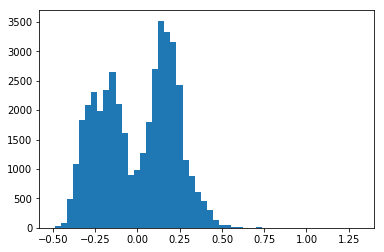

In [670]:
plt.hist(lasso4b_res, bins=50)

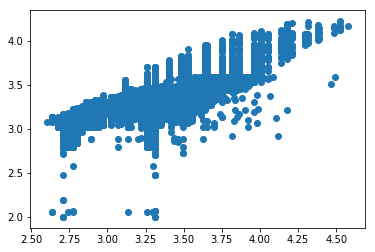

In [671]:
plt.scatter(Y_test4b, preds4b)

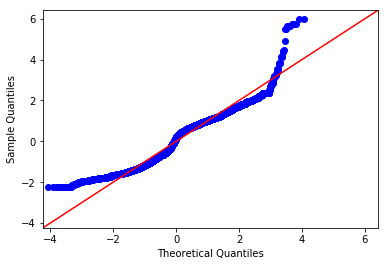

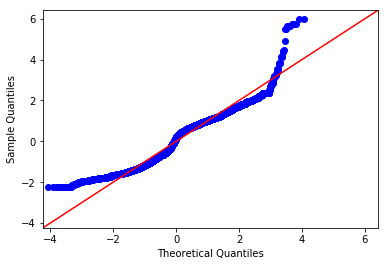

In [672]:
import scipy.stats as stats
sm.qqplot(lasso4b_res, stats.t, fit=True, line=str(45))

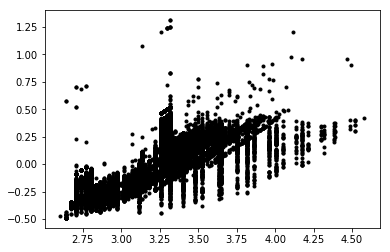

In [673]:
plt.plot(Y_test4b, lasso4b_res, 'k.')

In [674]:
from sklearn.linear_model import RidgeCV
ridge4b = RidgeCV()
ridge4b.fit(X_train4b, Y_train4b)
preds4br = ridge4.predict(X_test4b)
ridge4b.coef_

array([ 0.00000000e+00,  2.66623019e-01,  5.86039657e-03,  2.09362466e-03,
        2.61679026e-02, -1.25807227e-02, -5.20200772e-03,  3.07250501e-04,
        9.87605275e-01, -4.78061491e-02, -5.11018229e-02, -7.96724058e-02,
        1.22149448e-04,  9.91493915e-03, -5.55327123e-02,  8.70057166e-05,
       -9.86916284e-04, -7.10990122e-04, -2.48165060e-03,  2.77069003e-03,
        7.06494999e-04])

In [675]:
ridge4b.score(X_test4b, Y_test4b)

0.4137735228909599

In [676]:
ridge_res4b = Y_test4b - preds4br

In [677]:
mse4br = mean_squared_error(Y_test4b, preds4br)

In [678]:
np.exp(mse4br)

2.265044188371079

In [679]:
np.exp(Y_test4b).mean()

26.518099600935088

In [680]:
np.exp(mse4br)/np.exp(Y_test4b).mean()

0.08541502681026239

(array([1.000e+01, 2.200e+01, 4.400e+01, 7.800e+01, 3.270e+02, 8.860e+02,
        1.366e+03, 2.658e+03, 3.208e+03, 2.941e+03, 2.493e+03, 2.790e+03,
        2.104e+03, 1.668e+03, 1.633e+03, 2.522e+03, 3.391e+03, 3.875e+03,
        3.393e+03, 2.953e+03, 1.503e+03, 4.590e+02, 3.290e+02, 5.240e+02,
        4.940e+02, 3.410e+02, 1.640e+02, 1.140e+02, 9.000e+00, 6.000e+00,
        6.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 7.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.2455137 , 0.29033249, 0.33515129, 0.37997009, 0.42478889,
        0.46960769, 0.51442648, 0.55924528, 0.60406408, 0.64888288,
        0.69370168, 0.73852048, 0.78333927, 0.82815807, 0.87297687,
        0.91779567, 0.96261447, 1.00743326, 1.05225206, 1.09707086,
        1.14188966, 1.18670846, 1.23152725, 1.27634605, 1.32116485,
        1.36598365, 1.41080245, 1.45

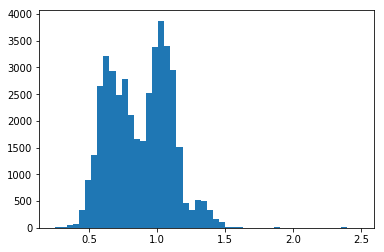

In [681]:
plt.hist(ridge_res4b, bins=50)

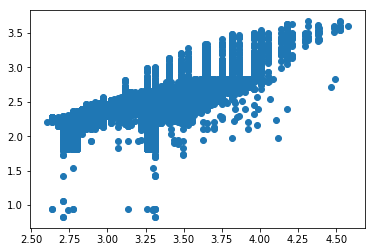

In [682]:
plt.scatter(Y_test4b, preds4br)

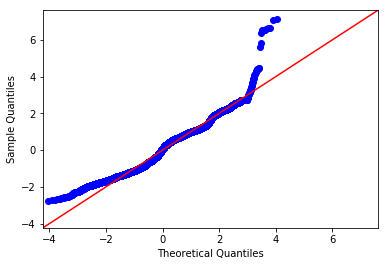

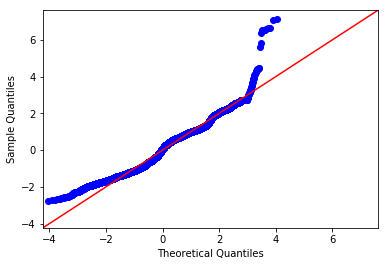

In [683]:
sm.qqplot(ridge_res4b, stats.t, fit=True, line=str(45))

### Spec2b:  rides not in the "black" categories

### a. Fit with plain OLS

In [621]:
X4 = merged_df[(merged_df.Black == 0)][['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d']]
X4 = sm.add_constant(X4)
Y4 = merged_df[(merged_df.Black == 0)]['lprice']

In [622]:
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4,Y4, test_size = .2, random_state=42)

In [627]:
model4 = sm.OLS(Y_train4, X_train4).fit()

In [628]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     6099.
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:36:32   Log-Likelihood:            -1.4397e+05
No. Observations:              338800   AIC:                         2.880e+05
Df Residuals:                  338779   BIC:                         2.882e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.9081      0.591      3.228      0.001       0.750       3.067
ldistance                               0.3352      0.001    298.987      0.000       0.333       0.337
ltemp                                   0.0081      0.005      1.786      0.074      -0.001       0.017
clouds                                 -0.0011      0.003     -0.427      0.669      -0.006       0.004
lpressure                               0.0290      0.085      0.342      0.732      -0.137       0.195
rain                                    0.0306      0.029      1.051      0.293      -0.026       0.088
lhumidity                              -0.0071      0.005     -1.395      0.163      -0.017       0.003
lwind                                  -0.0015      0.001     -1.117      0.264      -0.004       0.001
lsurge_multiplier                       1.3976      0.009    148.178      0.000       1.379       1.416
cab_type_Uber                           0.0040      0.001      3.116      0.002       0.001       0.007
destination_Back Bay                   -0.0258      0.002    -11.046      0.000      -0.030      -0.021
source_Beacon Hill                     -0.0505      0.002    -21.483      0.000      -0.055      -0.046
destination_Haymarket Square            0.0002      0.002      0.074      0.941      -0.005       0.005
destination_Northeastern University     0.0191      0.002      8.089      0.000       0.014       0.024
source_Back Bay                        -0.0277      0.002    -11.814      0.000      -0.032      -0.023
day_Fri                                -0.0028      0.002     -1.183      0.237      -0.007       0.002
AMPM_PM                                -0.0026      0.002     -1.507      0.132      -0.006       0.001
month_Dec                              -0.0022      0.002     -1.184      0.236      -0.006       0.001
sports                                 -0.0002      0.003     -0.094      0.925      -0.005       0.005
wkndPM                                  0.0028      0.003      0.977      0.329      -0.003       0.008
rain_d                                 -0.0004      0.002     -0.162      0.871      -0.005       0.004
==============================================================================
Omnibus:                    12328.335   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14494.888
Skew:                          -0.440   Prob(JB):                         0.00
Kurtosis:                       3.501   Cond. No.                     7.70e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The co

In [629]:
lasso4 = LassoCV()
lasso4.fit(X_train4, Y_train4)
preds4 = lasso4.predict(X_test4)
lasso4.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.34988413e-01,  8.10948233e-04, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -5.87287842e-04,
        1.37071144e+00,  2.94674909e-03, -2.40134453e-02, -4.84241125e-02,
       -0.00000000e+00,  1.73267044e-02, -2.53561232e-02, -3.61187228e-04,
       -0.00000000e+00, -6.69170032e-04,  0.00000000e+00,  1.96998993e-04,
        0.00000000e+00])

In [631]:
lasso4.score(X_test4, Y_test4)

0.2638662955719956

In [632]:
lasso4_res = Y_test4 - preds4

In [633]:
from sklearn.metrics import mean_squared_error
mse4 = mean_squared_error(Y_test4, preds4)

In [635]:
np.exp(mse4)

1.1459486819965348

In [636]:
np.exp(Y_test4).mean()

11.526081156066635

In [637]:
np.exp(mse4)/np.exp(Y_test4).mean()

0.09942222915837934

(array([8.000e+00, 1.200e+01, 6.700e+01, 8.700e+01, 1.000e+02, 1.760e+02,
        9.900e+01, 3.260e+02, 3.580e+02, 2.470e+02, 4.200e+02, 2.470e+02,
        2.870e+02, 4.430e+02, 6.060e+02, 1.900e+03, 1.590e+03, 1.863e+03,
        2.246e+03, 3.644e+03, 6.589e+03, 9.335e+03, 8.226e+03, 5.749e+03,
        4.283e+03, 2.542e+03, 2.350e+03, 3.489e+03, 5.286e+03, 6.148e+03,
        6.384e+03, 4.992e+03, 1.798e+03, 1.571e+03, 5.670e+02, 2.430e+02,
        1.360e+02, 9.700e+01, 5.500e+01, 6.000e+01, 3.100e+01, 2.000e+01,
        1.800e+01, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.61049871, -1.54439185, -1.47828498, -1.41217812, -1.34607125,
        -1.27996438, -1.21385752, -1.14775065, -1.08164379, -1.01553692,
        -0.94943006, -0.88332319, -0.81721633, -0.75110946, -0.6850026 ,
        -0.61889573, -0.55278887, -0.486682  , -0.42057514, -0.35446827,
        -0.28836141, -0.22225454, -0.15614767, -0.09004081, -0.02393394,
         0.

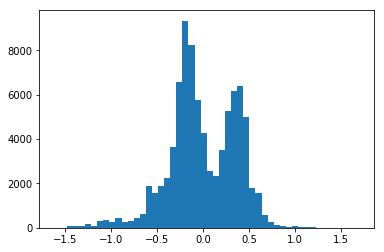

In [638]:
plt.hist(lasso4_res, bins=50)

### b. Perform Lasso & Ridge on the spec 2b model

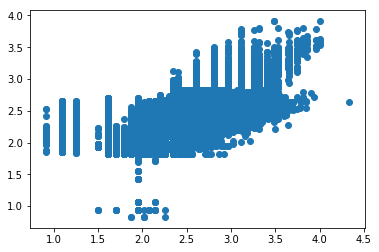

In [639]:
plt.scatter(Y_test4, preds4)

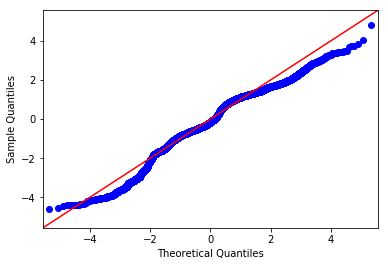

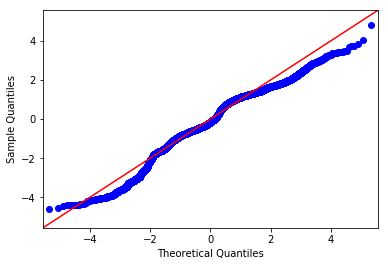

In [640]:
import scipy.stats as stats
sm.qqplot(lasso4_res, stats.t, fit=True, line=str(45))

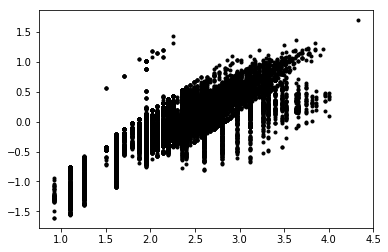

In [642]:
plt.plot(Y_test4, lasso4_res, 'k.')

In [643]:
from sklearn.linear_model import RidgeCV
ridge4 = RidgeCV()
ridge4.fit(X_train4, Y_train4)
preds4r = ridge4.predict(X_test4)
ridge4.coef_

array([ 0.00000000e+00,  3.35188331e-01,  8.03985270e-03, -1.11216184e-03,
        2.75884585e-02,  3.04695737e-02, -7.08704250e-03, -1.50289529e-03,
        1.39666645e+00,  3.99948004e-03, -2.58075816e-02, -5.05220510e-02,
        1.77226838e-04,  1.90596983e-02, -2.76651870e-02, -2.80654077e-03,
       -2.64529412e-03, -2.14062297e-03, -2.47992747e-04,  2.79218642e-03,
       -3.71447151e-04])

In [644]:
ridge4.score(X_test4, Y_test4)

0.26381726851132226

In [645]:
ridge_res4 = Y_test4 - preds4r

In [646]:
mse4r = mean_squared_error(Y_test4, preds4r)

In [647]:
np.exp(mse4r)

1.1459590794765673

In [649]:
np.exp(Y_test4).mean()

11.526081156066635

In [650]:
np.exp(mse4r)/np.exp(Y_test4).mean()

0.09942313124122013

(array([8.000e+00, 1.200e+01, 6.500e+01, 8.900e+01, 9.600e+01, 1.770e+02,
        9.300e+01, 3.260e+02, 3.670e+02, 2.430e+02, 4.140e+02, 2.540e+02,
        2.830e+02, 4.510e+02, 5.650e+02, 1.912e+03, 1.597e+03, 1.855e+03,
        2.270e+03, 3.587e+03, 6.661e+03, 9.307e+03, 8.236e+03, 5.747e+03,
        4.330e+03, 2.511e+03, 2.353e+03, 3.499e+03, 5.296e+03, 6.048e+03,
        6.380e+03, 5.052e+03, 1.798e+03, 1.560e+03, 5.910e+02, 2.400e+02,
        1.380e+02, 1.000e+02, 5.300e+01, 6.200e+01, 3.100e+01, 2.000e+01,
        1.800e+01, 1.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.61124367, -1.54511784, -1.47899201, -1.41286618, -1.34674035,
        -1.28061452, -1.21448869, -1.14836286, -1.08223703, -1.0161112 ,
        -0.94998537, -0.88385954, -0.81773371, -0.75160788, -0.68548205,
        -0.61935622, -0.55323039, -0.48710456, -0.42097873, -0.3548529 ,
        -0.28872707, -0.22260124, -0.15647541, -0.09034958, -0.02422375,
         0.

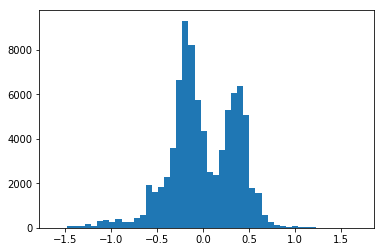

In [651]:
plt.hist(ridge_res4, bins=50)

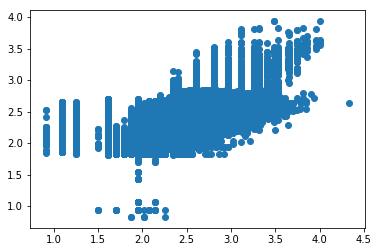

In [652]:
plt.scatter(Y_test4, preds4r)

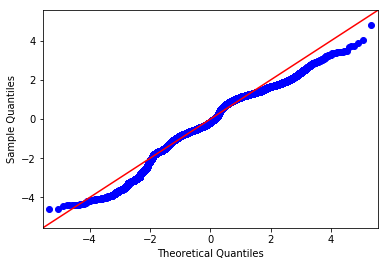

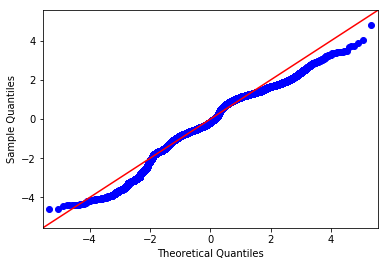

In [654]:
sm.qqplot(ridge_res4, stats.t, fit=True, line=str(45))

### Notes on Spec 2: Both Lasso and Ridge models have QQ plot showing more normal residuals, but the predictive power of this spec is quite poor (<0.3 Adjusted R Sq). 

### 3. Feature selection with Random Forest
### After several failed attempts at identifying a model with normal residuals and good predictive power, we decided to use random forest to help with feature selection.

In [378]:
XX= dataSet_df[['distance', 'surge_multiplier', 'temp', 'clouds', 'pressure', 
                        'rain', 'humidity', 'wind', 'name_Black', 'name_Black SUV', 
                        'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft', 
                        'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool', 'name_UberX', 
                        'name_UberXL', 'name_WAV', 'destination_Back Bay', 'destination_Beacon Hill', 
                        'destination_Boston University', 'destination_Fenway', 'destination_Financial District',
                        'destination_Haymarket Square', 'destination_North End', 'destination_North Station', 
                        'destination_Northeastern University', 'destination_South Station', 
                        'destination_Theatre District', 'destination_West End', 'source_Back Bay', 
                        'source_Beacon Hill', 'source_Boston University', 'source_Fenway',
                        'source_Financial District', 'source_Haymarket Square',
                        'source_North End', 'source_North Station',
                        'source_Northeastern University', 'source_South Station',
                         'source_Theatre District', 'source_West End']]
YY = dataSet_df['price']

In [379]:
X_train, X_test, y_train, y_test = train_test_split(XX.values, YY.values, test_size=0.33, random_state=42)

In [408]:
regr2 = RandomForestRegressor(max_depth=5, random_state=137, n_estimators=2000)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
           oob_score=False, random_state=137, verbose=0, warm_start=False)

In [409]:
fimpDict2 = {}
for fimp in list(zip(XX.columns, regr2.feature_importances_)):
    print(fimp)
    fimpDict2.update({fimp[0]:fimp[1]})

('distance', 0.08411159554577159)
('surge_multiplier', 0.004798135772894215)
('temp', 4.058997336139654e-08)
('clouds', 1.3079708087929082e-07)
('pressure', 2.559713669665222e-07)
('rain', 5.058205400501373e-08)
('humidity', 4.494692498683774e-07)
('wind', 8.703892792528805e-08)
('name_Black', 0.10285456211881895)
('name_Black SUV', 0.30573628116164037)
('name_Lux', 0.055831286838348856)
('name_Lux Black', 0.12507198862350913)
('name_Lux Black XL', 0.32110437716214707)
('name_Lyft', 0.0)
('name_Lyft XL', 0.0)
('name_Shared', 0.0)
('name_Taxi', 0.0)
('name_UberPool', 0.0)
('name_UberX', 0.0)
('name_UberXL', 0.0)
('name_WAV', 0.0)
('destination_Back Bay', 0.00014439988558463074)
('destination_Beacon Hill', 1.8422604099186783e-10)
('destination_Boston University', 1.0964727054163061e-09)
('destination_Fenway', 9.071226103555381e-07)
('destination_Financial District', 6.982415602747525e-06)
('destination_Haymarket Square', 4.232965322789462e-05)
('destination_North End', 1.6964724484275228

In [410]:
kk = list(fimpDict.keys())
vv = list(fimpDict.values())


fimpDF = pd.DataFrame({'features':kk,
                      'importance':vv})

In [411]:
fimpDF.sort_values(by='importance')

,features,importance
22,destination_Beacon Hill,0.000000
23,destination_Boston University,0.000000
24,destination_Fenway,0.000000
25,destination_Financial District,0.000000
27,destination_North End,0.000000
28,destination_North Station,0.000000
30,destination_South Station,0.000000
31,destination_Theatre District,0.000000
43,source_Theatre District,0.000000
32,destination_West End,0.000000


### 4. Spec 3: features selected based on random forest model

### a. Fit with plain OLS

In [328]:
X3 = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'lsurge_multiplier', 
       'cab_type_Uber', 'destination_Back Bay','source_Beacon Hill',
       'destination_Haymarket Square', 'destination_Northeastern University',
       'source_Back Bay', 'day_Fri',
       'AMPM_PM', 'month_Dec', 'sports', 'wkndPM', 'rain_d', 'Black']]
X3 = sm.add_constant(X3)
Y3 = merged_df['lprice']

/Users/ptw/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [329]:
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3,Y3, test_size = .2, random_state=42)

In [334]:
model3 = sm.OLS(Y_train3, X_train3).fit()

In [335]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lprice   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                 4.832e+04
Date:                Wed, 31 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:33:58   Log-Likelihood:            -1.5528e+05
No. Observations:              508193   AIC:                         3.106e+05
Df Residuals:                  508171   BIC:                         3.108e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.9118      0.428      4.467      0.000       1.073       2.751
ldistance                               0.3121      0.001    384.194      0.000       0.310       0.314
ltemp                                   0.0037      0.003      1.138      0.255      -0.003       0.010
clouds                                 -0.0013      0.002     -0.685      0.493      -0.005       0.002
lpressure                               0.0346      0.061      0.564      0.573      -0.086       0.155
rain                                    0.0130      0.021      0.620      0.535      -0.028       0.054
lhumidity                              -0.0044      0.004     -1.200      0.230      -0.012       0.003
lwind                                  -0.0009      0.001     -0.975      0.329      -0.003       0.001
lsurge_multiplier                       1.2407      0.007    189.530      0.000       1.228       1.253
cab_type_Uber                          -0.0132      0.001    -14.131      0.000      -0.015      -0.011
destination_Back Bay                   -0.0336      0.002    -19.846      0.000      -0.037      -0.030
source_Beacon Hill                     -0.0608      0.002    -35.644      0.000      -0.064      -0.058
destination_Haymarket Square            0.0012      0.002      0.666      0.505      -0.002       0.005
destination_Northeastern University     0.0136      0.002      7.930      0.000       0.010       0.017
source_Back Bay                        -0.0360      0.002    -21.159      0.000      -0.039      -0.033
day_Fri                                -0.0029      0.002     -1.665      0.096      -0.006       0.001
AMPM_PM                                -0.0016      0.001     -1.288      0.198      -0.004       0.001
month_Dec                              -0.0014      0.001     -1.041      0.298      -0.004       0.001
sports                                  0.0009      0.002      0.452      0.652      -0.003       0.005
wkndPM                                  0.0019      0.002      0.901      0.368      -0.002       0.006
rain_d                                  0.0007      0.002      0.424      0.672      -0.003       0.004
Black                                   0.8763      0.001    896.200      0.000       0.874       0.878
==============================================================================
Omnibus:                    25233.277   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39370.791
Skew:                          -0.436   Prob(JB):                         0.00
Kurtosis:                       4.049   Cond. No.                     7.70e+03
==============================================================================

Warnings

### b. Perform Lasso & Ridge on the spec 3 model

In [336]:
lasso3 = LassoCV()
lasso3.fit(X_train3, Y_train3)
preds3 = lasso3.predict(X_test3)
lasso3.coef_

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.00000000e+00,  3.11671945e-01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -1.45908126e-04,
        1.20168222e+00, -1.34054542e-02, -3.06886970e-02, -5.71948845e-02,
        0.00000000e+00,  1.05642315e-02, -3.20043335e-02, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.75597434e-01])

In [337]:
lasso3.score(X_test3, Y_test3)

0.6680802411457678

In [338]:
lasso3_res = Y_test3 - preds3

In [593]:
mse3 = mean_squared_error(Y_test3, preds3)

In [594]:
np.exp(mse3)

1.1136543158810746

In [595]:
np.exp(Y_test3).mean()

16.54675518894285

In [596]:
np.exp(mse3)/np.exp(Y_test3).mean()

0.06730348658480542

(array([8.0000e+00, 1.3000e+01, 8.6000e+01, 1.0200e+02, 1.4900e+02,
        1.3600e+02, 2.3800e+02, 3.7900e+02, 1.6000e+02, 3.6500e+02,
        4.0900e+02, 1.9400e+02, 3.3700e+02, 4.3500e+02, 1.0120e+03,
        2.0360e+03, 1.1280e+03, 2.1910e+03, 3.5000e+03, 7.8940e+03,
        1.1436e+04, 1.2362e+04, 1.3022e+04, 8.1910e+03, 6.1970e+03,
        6.1350e+03, 8.6980e+03, 8.7130e+03, 7.5790e+03, 7.4830e+03,
        6.9110e+03, 4.8050e+03, 1.8990e+03, 1.5930e+03, 5.5500e+02,
        2.3000e+02, 1.4400e+02, 9.1000e+01, 9.0000e+01, 4.2000e+01,
        3.5000e+01, 2.4000e+01, 1.5000e+01, 6.0000e+00, 6.0000e+00,
        9.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.58941079, -1.52373868, -1.45806656, -1.39239444, -1.32672232,
        -1.2610502 , -1.19537809, -1.12970597, -1.06403385, -0.99836173,
        -0.93268962, -0.8670175 , -0.80134538, -0.73567326, -0.67000114,
        -0.60432903, -0.53865691, -0.47298479, -0.40731267, -0.34164056,
        -0.27596844, -0.21

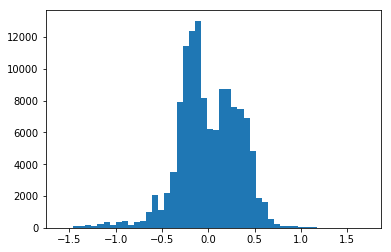

In [598]:
plt.hist(lasso3_res, bins=50)

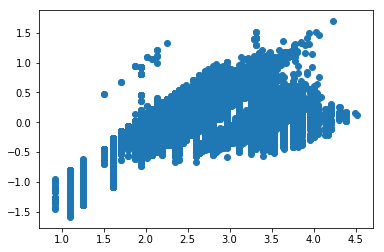

In [339]:
plt.scatter(Y_test3, lasso3_res)

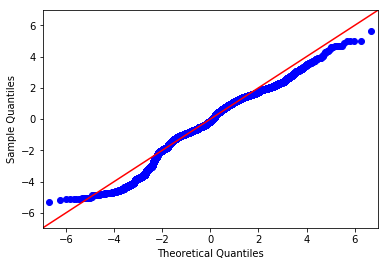

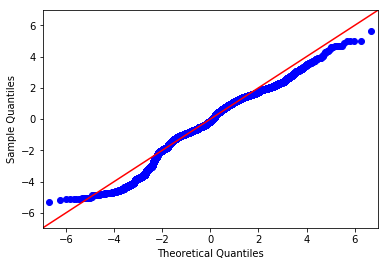

In [600]:
import scipy.stats as stats
sm.qqplot(lasso3_res, stats.t, fit=True, line=str(45))

In [607]:
from sklearn.linear_model import RidgeCV
ridge3 = RidgeCV()
ridge3.fit(X_train3, Y_train3)
preds3r = ridge3.predict(X_test3)
ridge3.coef_

array([ 0.00000000e+00,  3.12067041e-01,  3.70675007e-03, -1.29146313e-03,
        3.34274900e-02,  1.30355274e-02, -4.41817684e-03, -9.52522934e-04,
        1.24016261e+00, -1.32406881e-02, -3.35837436e-02, -6.08440523e-02,
        1.16028663e-03,  1.35500956e-02, -3.59572201e-02, -2.86429665e-03,
       -1.63899708e-03, -1.35962165e-03,  8.62948538e-04,  1.86735574e-03,
        7.29782043e-04,  8.76339861e-01])

In [608]:
ridge3.score(X_test3, Y_test3)

0.6680963314487726

In [609]:
ridge3_res = Y_test3 - preds3r

In [610]:
mse3r = mean_squared_error(Y_test3, preds3r)

In [611]:
np.exp(mse3r)

1.1136485044719757

In [612]:
np.exp(Y_test3).mean()

16.54675518894285

In [613]:
np.exp(mse3r)/np.exp(Y_test3).mean()

0.0673031353734028

(array([7.0000e+00, 1.3000e+01, 8.0000e+01, 1.0800e+02, 1.4300e+02,
        1.3400e+02, 2.1200e+02, 3.8700e+02, 1.6700e+02, 3.5800e+02,
        4.3100e+02, 1.9400e+02, 3.3100e+02, 4.4400e+02, 9.7200e+02,
        2.0240e+03, 1.1640e+03, 2.1870e+03, 3.4960e+03, 7.7020e+03,
        1.1345e+04, 1.2330e+04, 1.3172e+04, 8.2790e+03, 6.2080e+03,
        6.1630e+03, 8.6600e+03, 8.7880e+03, 7.6700e+03, 7.3220e+03,
        6.9730e+03, 4.8280e+03, 1.8880e+03, 1.5980e+03, 5.6200e+02,
        2.3800e+02, 1.4400e+02, 9.4000e+01, 8.8000e+01, 4.5000e+01,
        3.3000e+01, 2.5000e+01, 1.5000e+01, 6.0000e+00, 6.0000e+00,
        9.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.59297832, -1.5272008 , -1.46142328, -1.39564575, -1.32986823,
        -1.26409071, -1.19831319, -1.13253567, -1.06675815, -1.00098062,
        -0.9352031 , -0.86942558, -0.80364806, -0.73787054, -0.67209302,
        -0.60631549, -0.54053797, -0.47476045, -0.40898293, -0.34320541,
        -0.27742789, -0.21

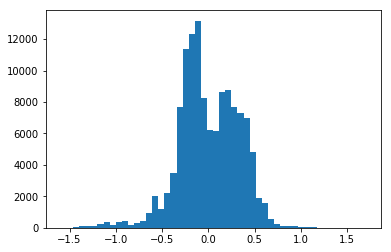

In [614]:
plt.hist(ridge3_res, bins=50)

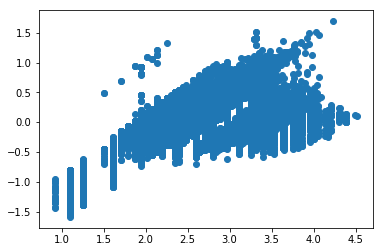

In [615]:
plt.scatter(Y_test3, ridge3_res)

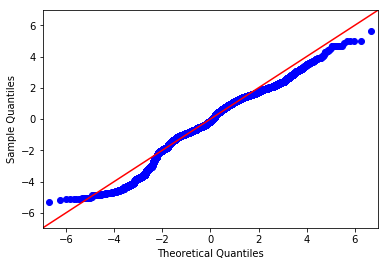

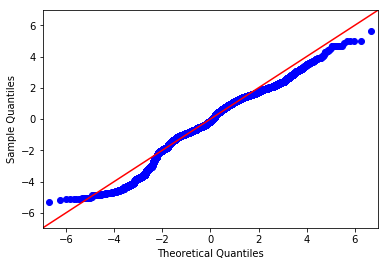

In [616]:
sm.qqplot(ridge3_res, stats.t, fit=True, line=str(45))

### Notes on Spec 3: this model has the most normal residuals, decent scores (Adjusted R Sq. > 0.66) and relatively low MSE. It's the best linear fit for this data set.

## III. Logistic Regression with Cross Validation

### Next, we'll try to predict the surge multiplier using a logistic model. Surge multiplier is encoded as 1 when it's over 1, and 0 otherwise.

In [191]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [348]:
X = merged_df[['ldistance','ltemp', 'clouds',
       'lpressure', 'rain', 'lhumidity', 'lwind',
       'cab_type_Lyft', 'destination_Back Bay',
       'destination_Boston University', 'surge_multiplier',
       'destination_Fenway', 'destination_Financial District',
       'destination_Haymarket Square', 'destination_North End',
       'destination_North Station', 'destination_Northeastern University',
       'destination_South Station', 'destination_Theatre District',
       'destination_West End', 'source_Back Bay', 
       'source_Boston University', 'source_Fenway',
       'source_Financial District', 'source_Haymarket Square',
       'source_North End', 'source_North Station',
       'source_Northeastern University', 'source_South Station',
       'source_Theatre District', 'source_West End', 'name_Black',
       'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
       'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
       'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
       'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
       'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
       'week_49', 'sports', 'wkndPM']]
X = X[X.cab_type_Lyft == 1]

# X = sm.add_constant(X)
y = (X.surge_multiplier != 1).astype(int)
X.drop('surge_multiplier', axis=1, inplace=True)

In [349]:
#test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=24)

In [350]:
print('Train:', X_train.shape, y_train.shape ,'\n', 'y1 train:', y_train.sum(),'\n',
       'Test:', X_test.shape, y_test.shape,'\n', 'y1 test:', y_test.sum())

Train: (244881, 55) (244881,) 
 y1 train: 16707 
 Test: (61221, 55) (61221,) 
 y1 test: 4177


### Because the train set is quite large, the LogisticRegressionCV model took a very long time to run. The classes in this data set is also imbalanced (positive target ~3%). We decide to use a resampling technique (similar to bagging) by first separating the dataframe into observation with target equal 0 and 1, and sampling the exact amount of positive targets (~16k) from the subset with negative target to create a data frame with balanced classes.

In [351]:
mytrain = copy.deepcopy(X_train)
mytrain['y'] = y_train

In [352]:
Xy1 = mytrain[mytrain['y']==1]
Xy0 = mytrain[mytrain['y']==0]

In [249]:
# This function take in the logistic regression, list of features, number of samples, and number of loops as arguments,
# resample the two subset of dataframes, and return the score and predictions as lists. It also return the coefficients
# of the model with the highest score in the loop.
def baglr(lr, features, n, nloop):
    lrcoeff = []
    lrscore = []
    lrpred = []
    for i in range(nloop):
        mySample1 = Xy1.sample(n, replace=True, random_state=i)
        mySample = mySample1.append(Xy0.sample(n, replace=True))
        mySample.reset_index(inplace=True, drop=True)
        y_sample = mySample['y']
        x_sample = mySample[features]
        lr.fit(x_sample, y_sample)
        print(lr.score(x_sample, y_sample), '\n', lr.coef_)
        lrscore.append(copy.deepcopy(lr.score(x_sample, y_sample)))
        lrcoeff.append(copy.deepcopy(lr.coef_))
        lrpred.append(copy.deepcopy(lr.predict(X_test)))
        probs = lr.predict_proba(X_test)
        preds = probs[:, 1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    besti = lrscore.index(max(lrscore))
    lrcoefs = {}
    for i in range(0, len(features)):
        lrcoefs.update({features[i]: lrcoeff[besti][0][i]})
    return lrcoefs, lrscore, lrpred

### We first try to fit with the logistic regression with cross validation and L1 regularization 10 times and get the average score.

In [354]:
lrp1a = LogisticRegressionCV(penalty='l1', solver='liblinear', n_jobs= -1)

In [358]:
features1 = ['ldistance','ltemp', 'clouds',
           'lpressure', 'rain', 'lhumidity', 'lwind',
           'cab_type_Lyft', 'destination_Back Bay',
           'destination_Boston University',
           'destination_Fenway', 'destination_Financial District',
           'destination_Haymarket Square', 'destination_North End',
           'destination_North Station', 'destination_Northeastern University',
           'destination_South Station', 'destination_Theatre District',
           'destination_West End', 'source_Back Bay', 
           'source_Boston University', 'source_Fenway',
           'source_Financial District', 'source_Haymarket Square',
           'source_North End', 'source_North Station',
           'source_Northeastern University', 'source_South Station',
           'source_Theatre District', 'source_West End', 'name_Black',
           'name_Black SUV', 'name_Lux', 'name_Lux Black', 'name_Lux Black XL',
           'name_Lyft', 'name_Lyft XL', 'name_Shared', 'name_Taxi',
           'name_UberPool', 'name_UberX', 'name_UberXL', 'day_Fri',
           'day_Mon', 'day_Sat', 'day_Thu', 'day_Tue', 'day_Wed',
           'AMPM_PM', 'month_Dec', 'week_47', 'week_48',
           'week_49', 'sports', 'wkndPM']

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8246842640809242 
 [[ 6.64317165e-02  0.00000000e+00 -1.57631269e-01  1.60678625e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.98621053e+00
   6.58996684e-02  0.00000000e+00  0.00000000e+00  7.24942046e-02
   0.00000000e+00  0.00000000e+00 -3.30434145e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.09990848e-01
   1.29995146e-01  1.81742676e-01 -2.87569379e-01 -1.44763239e+00
  -1.54030712e+00 -8.16162830e-01  2.25615215e-01 -7.87794973e-02
   2.08504095e-01 -7.01711064e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.31164255e-02  3.12960864e-02
   0.00000000e+00 -5.11093279e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.64054873e-02
  -2.13266848e-02  2.28271719e-02  0.00000000e+00  0.00000000e+00
   6.68714972e-02  0.00000000e+00  0.00000000e+00  5.26034092e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]


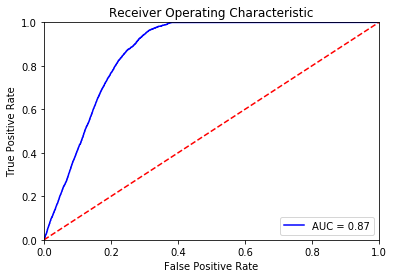

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8241156401508349 
 [[ 8.16727836e-02  0.00000000e+00 -1.53114280e-01  1.52218790e-01
   0.00000000e+00  0.00000000e+00  9.22898397e-03 -6.95219900e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.01631086e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.56662152e-02  3.47749114e-01
   1.24495134e-01  2.29583893e-01 -1.28168725e-01 -1.44938341e+00
  -1.66131077e+00 -8.18867373e-01  2.56704298e-01 -4.48839443e-02
   2.19713881e-01 -7.33093567e-01  0.00000000e+00  0.00000000e+00
   7.22592558e-02  0.00000000e+00  0.00000000e+00  8.41076467e-02
   0.00000000e+00 -5.06104020e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.52653562e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.14731365e-02
   1.85999226e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.02629126e-02]]


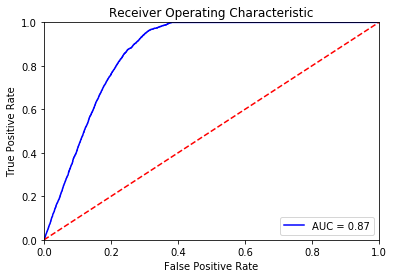

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8230382474411924 
 [[ 9.78093840e-03 -8.63408808e-02 -1.20126513e-01  1.62995736e-01
   0.00000000e+00  1.56170092e-01  5.06777924e-02 -9.02724858e+00
   4.87545621e-02  1.34549016e-01 -1.49811633e-02  0.00000000e+00
  -3.98706290e-02  6.94025346e-02 -5.72468214e-03  0.00000000e+00
   2.22830596e-03  9.99464950e-02  7.57816260e-03  4.01678737e-01
   2.30599053e-01  2.79158337e-01 -2.42126676e-01 -1.64328230e+00
  -1.70257971e+00 -8.82769904e-01  3.29661153e-01 -1.00212307e-01
   2.51851854e-01 -7.24155500e-01  0.00000000e+00  0.00000000e+00
   6.47499261e-02 -4.88720246e-02  8.06968363e-02  5.09898049e-02
   0.00000000e+00 -7.13619290e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.64299175e-03
  -1.45230753e-01  5.93438756e-02  8.00984346e-02  4.65541016e-02
   8.41054447e-02  2.19918079e-01  1.58276224e-01 -1.15195007e-01
   6.75386321e-02 -1.60757462e-01  1.67511343e-01]]


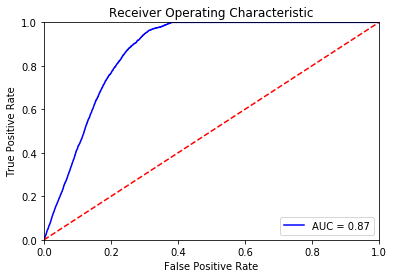

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8226791165379781 
 [[ 8.42862286e-02  1.26203938e-01 -4.98827827e-02  6.01422992e-02
   0.00000000e+00 -1.19866668e-01  2.23322613e-02 -9.06801463e+00
   1.25715947e-01  0.00000000e+00  1.17287888e-02  1.35160316e-01
  -7.10729706e-04  5.02025040e-02  6.60904274e-02  0.00000000e+00
  -7.12861218e-02  2.04292200e-01  4.78680940e-02  3.57178453e-01
   7.17637752e-02  9.67906978e-02 -3.68908647e-01 -1.74639019e+00
  -1.72739518e+00 -1.00368459e+00  1.52989698e-01 -2.81015289e-01
   2.06238538e-01 -8.34852754e-01  0.00000000e+00  0.00000000e+00
   7.12460531e-03 -5.07773799e-02  0.00000000e+00  2.19129646e-02
   7.40131464e-02 -7.15315499e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.87716686e-02  2.66783003e-02
   3.73588261e-03  1.19375615e-01  3.40813457e-02  0.00000000e+00
   6.89528128e-02  1.13981286e-01  9.28087296e-02 -4.26559566e-02
   1.49777438e-02 -1.69225242e-02  6.49397912e-02]]


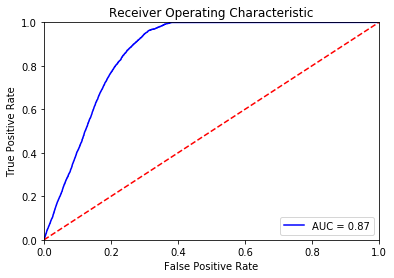

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8274675285808344 
 [[ 1.97524548e-02  4.90898200e-02 -6.98038407e-02  1.37119172e-01
   0.00000000e+00  0.00000000e+00 -5.69213533e-03 -6.99450299e+00
   0.00000000e+00  0.00000000e+00 -1.51172382e-02  0.00000000e+00
   0.00000000e+00  4.20161993e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.09351532e-02 -3.62379233e-02  3.87208109e-01
   1.55793373e-01  2.72300335e-01 -2.36951738e-01 -1.65087171e+00
  -1.72563346e+00 -7.91819706e-01  2.90616926e-01 -1.60969150e-01
   1.39033116e-01 -7.45483898e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  3.20601162e-02
   8.51836681e-03 -5.09174999e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.07621013e-04 -3.12620227e-02  0.00000000e+00  0.00000000e+00
   3.78699143e-02  0.00000000e+00  1.40493752e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]


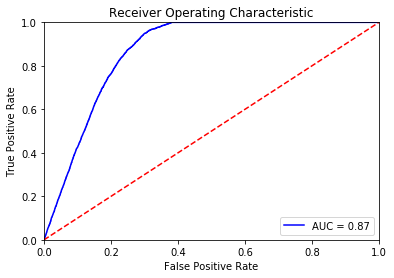

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8210630274735141 
 [[ 9.00279268e-02  0.00000000e+00 -3.36946122e-02  1.46091222e-01
   0.00000000e+00 -6.55553326e-03  1.63989664e-02 -6.98402494e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  6.30892336e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.29446969e-02 -5.13724228e-02  3.21474755e-01
   1.24955748e-01  2.54307262e-01 -2.85022235e-01 -1.41284188e+00
  -1.56893292e+00 -8.80695848e-01  1.52437776e-01 -2.24585427e-01
   1.07815503e-01 -7.41979969e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.41626361e-02
   0.00000000e+00 -5.02667072e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.95033957e-02  1.59772165e-02  0.00000000e+00
   4.73972976e-02  0.00000000e+00  4.49523231e-02  0.00000000e+00
  -2.16810254e-02  0.00000000e+00  0.00000000e+00]]


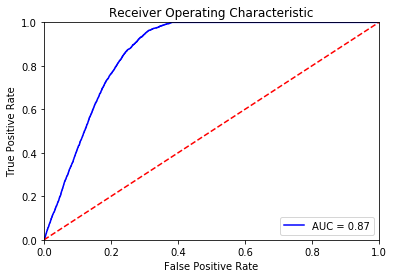

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8254324534626205 
 [[ 2.07112235e-02  9.73106267e-02 -1.74851400e-01 -1.35823888e-02
  -5.25020319e-01  9.68463791e-02  1.07878320e-01 -1.45342640e+01
   1.76572202e-01  7.60713120e-02 -6.07583982e-03  1.85338901e-01
   1.46305820e-02 -9.31626165e-03 -4.87109961e-03  2.84227325e-03
  -5.89761800e-03  1.80741023e-01  1.37305251e-01  4.42778109e-01
   2.86006131e-02  2.08716791e-01 -2.86486418e-01 -1.67513792e+00
  -1.74536414e+00 -9.62684830e-01  2.67573375e-01 -2.88637167e-01
   2.07201770e-01 -7.52260065e-01  0.00000000e+00  0.00000000e+00
   7.21850311e-01  7.23242451e-01  6.55692635e-01  7.44206691e-01
   6.94431682e-01 -1.26951664e+01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.36822325e-01 -4.92512102e-02
  -3.25163289e-01 -1.72894314e-01 -5.39054898e-03 -1.07891698e-01
   1.45960668e-02  2.78789801e-01  2.80823750e-01  2.75237720e-02
   1.93682893e-01 -5.30659791e-02  4.54388223e-02]]


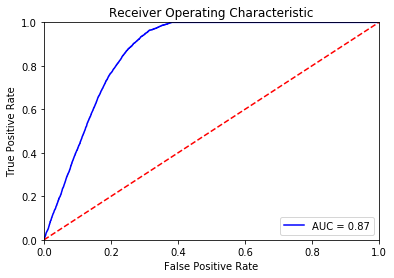

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8272580355539594 
 [[ 5.05225963e-02  1.60194685e-01 -1.99554963e-01  8.79460607e-02
   0.00000000e+00  5.99583955e-02  1.83743330e-02 -9.04640247e+00
   7.33534897e-02 -8.38287667e-02 -5.53273052e-02  4.20624647e-02
   8.38037399e-03  0.00000000e+00 -2.66067269e-02  4.40520959e-02
   0.00000000e+00  1.62102679e-01  0.00000000e+00  3.49522185e-01
   1.21563928e-01  1.71947715e-01 -3.57448559e-01 -1.77525776e+00
  -1.78730961e+00 -9.80067820e-01  1.00567612e-01 -1.64373495e-01
   1.73945845e-01 -8.54113284e-01  0.00000000e+00  0.00000000e+00
   5.19630740e-02  1.14104018e-01  1.80145840e-02 -6.00701214e-03
   0.00000000e+00 -7.18199680e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.21637435e-01  4.72000655e-02
   0.00000000e+00  0.00000000e+00  2.82054729e-02  4.10596721e-02
   8.47038753e-02  0.00000000e+00  2.57051750e-03 -6.89743684e-02
   3.83031169e-02  0.00000000e+00  0.00000000e+00]]


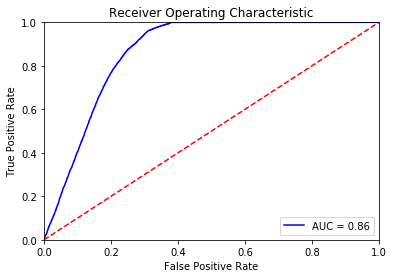

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8271682528281559 
 [[ 1.66136945e-02  0.00000000e+00 -6.20628572e-02  1.40341468e-01
   0.00000000e+00  0.00000000e+00  2.66633643e-02 -6.99303062e+00
   3.69251831e-02  4.48960335e-02  0.00000000e+00  0.00000000e+00
  -3.50763742e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  4.82097289e-01
   2.38722265e-01  2.69894874e-01 -1.88111724e-01 -1.51674974e+00
  -1.59461678e+00 -7.92915673e-01  3.49850011e-01  0.00000000e+00
   2.36501922e-01 -5.54510598e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.04518835e-02  2.94099151e-02  6.03454977e-02
   0.00000000e+00 -5.11319413e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.23182481e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.70385068e-02  1.24153679e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]


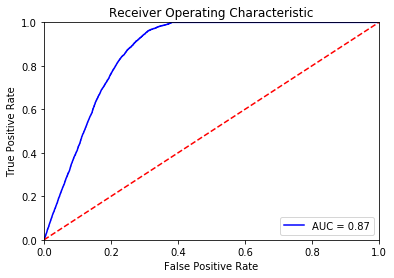

/Users/ptw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8229484647153887 
 [[ 2.47075665e-02  0.00000000e+00 -1.65652505e-01  1.80186111e-01
   2.97289157e-02 -7.48987453e-02 -4.70376413e-03 -9.04200273e+00
   9.68208476e-02  4.60334255e-02  0.00000000e+00  4.65008563e-02
  -8.58005235e-04  4.04588468e-02  0.00000000e+00  3.44984102e-02
  -2.09184120e-02  1.15452987e-01  5.45101789e-02  2.20581464e-01
   5.77560194e-02  1.61414585e-01 -4.00987175e-01 -1.75947348e+00
  -1.64268706e+00 -9.85470972e-01  1.57042733e-01 -3.02363488e-01
   1.49717485e-01 -7.63048781e-01  0.00000000e+00  0.00000000e+00
   3.91015653e-02  1.25946103e-02 -3.93806762e-03  4.51240443e-02
   0.00000000e+00 -7.16121172e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -1.98409315e-02  4.52011969e-02
  -1.15312978e-02  6.36742364e-03  5.54101969e-02  0.00000000e+00
   3.62348297e-02  8.75914639e-03 -6.01506675e-02 -6.13847789e-03
  -4.00084698e-02 -3.92871469e-02  6.42667372e-02]]


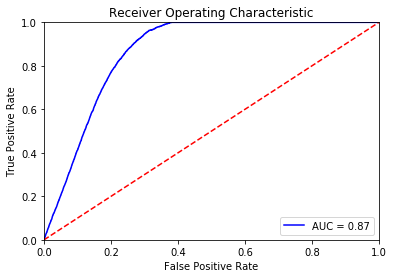

In [278]:
lrp1af16kcoef, lrp1af16kscore, lrp1af16kpred = baglr(lrp1a,features1,16707,10)

In [279]:
lrp1af16kcoef

{'ldistance': 0.01975245481895345,
 'ltemp': 0.04908982002105225,
 'clouds': -0.0698038406516203,
 'lpressure': 0.1371191720317873,
 'rain': 0.0,
 'lhumidity': 0.0,
 'lwind': -0.005692135332026598,
 'cab_type_Uber': -6.994502986410636,
 'destination_Back Bay': 0.0,
 'destination_Boston University': 0.0,
 'destination_Fenway': -0.015117238172653908,
 'destination_Financial District': 0.0,
 'destination_Haymarket Square': 0.0,
 'destination_North End': 0.004201619933607353,
 'destination_North Station': 0.0,
 'destination_Northeastern University': 0.0,
 'destination_South Station': 0.0,
 'destination_Theatre District': 0.0509351531677749,
 'destination_West End': -0.03623792333526516,
 'source_Back Bay': 0.3872081093441132,
 'source_Boston University': 0.15579337282759573,
 'source_Fenway': 0.27230033473577786,
 'source_Financial District': -0.23695173750148465,
 'source_Haymarket Square': -1.6508717069387338,
 'source_North End': -1.7256334562184188,
 'source_North Station': -0.79181970

In [288]:
np.mean(lrp1af16kscore)

0.8245855030825403

In [282]:
lrp1af16kpred

[array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0])]

### We then fit the logistic regression with cross validation and L2 regularization 10 times and get the average.

In [290]:
lr_l2 = LogisticRegressionCV(penalty='l2', cv=5, solver='liblinear', n_jobs= -1)

0.8203746932423535 
 [[ 0.0452062   0.11688441 -0.11135642 -0.1166587   0.01785885  0.09485206
  -0.04024841 -3.84695572  0.01539808  0.13864836  0.13309278  0.0944754
   0.05697392  0.14913684 -0.07505443  0.12291813  0.05552875  0.04512443
  -0.01993413  0.59197166  0.48755296  0.49711372 -0.12942877 -1.14843308
  -1.16783467 -0.70051538  0.58309047  0.07910275  0.48277602 -0.57221087
  -0.57448646 -0.55718277  1.27105244  1.27854858  1.33239326  1.35550174
   1.29544032 -2.6990897   0.         -0.56386007 -0.57655059 -0.56532005
  -0.01743302  0.01071602  0.00887511  0.10027932  0.11734627  0.07495058
   0.08998799 -0.00828257 -0.06980251 -0.04752412 -0.1086266  -0.13245587
   0.09170096]]


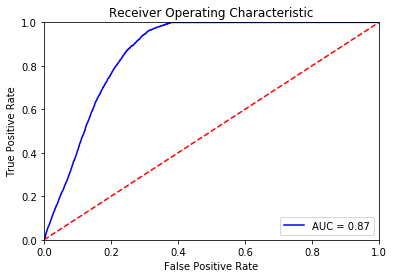

0.8272281079786916 
 [[ 0.01605728 -0.19591221 -0.14383836  0.02320086 -0.03936319  0.05963572
   0.02398768 -3.8607461   0.04167616  0.12385032  0.15829007  0.02499835
   0.16701394  0.17253333 -0.08243195  0.18965356  0.14595936 -0.0237114
  -0.07905317  0.39258948  0.40294199  0.50868817 -0.11081623 -1.27091879
  -1.28423727 -0.7960769   0.55367409  0.13822472  0.33402766 -0.52782523
  -0.57892535 -0.55310241  1.37228339  1.27088358  1.28406863  1.34230783
   1.34455222 -2.74767606  0.         -0.56290052 -0.55921209 -0.57817666
   0.01623284  0.13110794  0.01876151  0.08463269  0.07147346  0.05108726
   0.00444916  0.0292159   0.0692828   0.06760632 -0.07497122 -0.0692271
   0.21968874]]


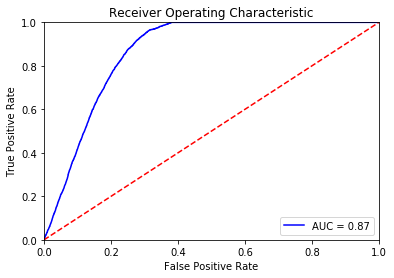

0.8270186149518166 
 [[ 6.86140482e-02 -3.88183969e-02 -6.54717558e-02 -6.56344387e-02
   5.28691910e-02  5.49808589e-02  3.37710361e-02 -3.85543096e+00
   3.81971267e-02  2.79681524e-01  1.18945376e-01 -2.68429529e-03
   1.22476890e-01  3.14869294e-01 -7.60540257e-02  1.54593018e-01
   2.06780178e-01  7.68878276e-02 -6.56380725e-03  3.54749549e-01
   4.31568899e-01  4.18839298e-01 -2.74417169e-01 -1.21613966e+00
  -1.40881858e+00 -8.53388462e-01  5.29042458e-01  4.10234059e-02
   2.21077764e-01 -5.83076535e-01 -5.74030719e-01 -5.88824382e-01
   1.31087570e+00  1.27405788e+00  1.35436291e+00  1.33871187e+00
   1.32833752e+00 -2.75805282e+00  0.00000000e+00 -5.86305446e-01
  -5.57669000e-01 -5.63943971e-01  7.27200357e-02  4.74808645e-02
  -4.51070357e-03  6.88838169e-02  3.41065784e-02  5.42338684e-02
   2.99777226e-02  8.43572086e-02  3.44601200e-02 -6.91689955e-02
  -6.35719109e-02 -6.51067035e-02  1.09994147e-01]]


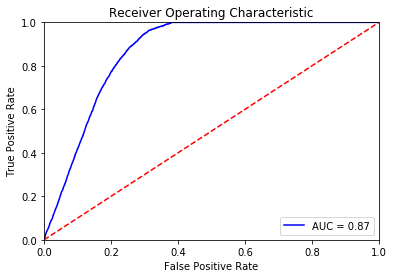

0.8241156401508349 
 [[ 4.99652397e-02 -2.03194496e-01 -1.84005521e-02 -1.26008412e-01
  -9.03466772e-01 -1.69610176e-01  8.54193234e-02 -6.32294019e+00
   1.28834379e-01  3.65063645e-01  2.45370763e-01  6.33893622e-02
   2.51852485e-01  2.67361564e-01 -3.03307296e-02  3.10231937e-01
   2.17252409e-01  1.98792009e-01  4.74195096e-02  3.17844096e-01
   3.59216382e-01  4.44092734e-01 -4.16086528e-01 -1.43521806e+00
  -1.46108162e+00 -8.54078248e-01  4.14628060e-01 -2.81624046e-02
   1.77208493e-01 -8.12335086e-01 -8.49014379e-01 -8.62623131e-01
   2.29694931e+00  2.26183642e+00  2.34559845e+00  2.28773005e+00
   2.35052048e+00 -5.26908662e+00  0.00000000e+00 -8.51602093e-01
  -8.42875749e-01 -8.49328352e-01  3.20456523e-03  7.45640140e-03
   5.41775239e-03 -3.53978129e-02 -5.64800519e-03 -1.32619490e-01
   1.05103514e-02 -1.21400149e-02  7.25419816e-02  2.87188082e-03
   2.75428241e-02 -5.33348743e-02  1.39908983e-01]]


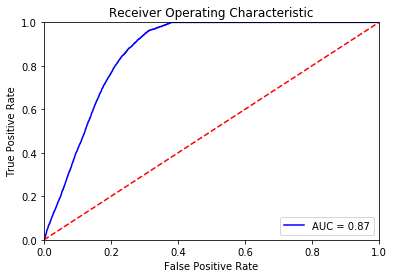

0.8248039743819956 
 [[ 0.11709749  0.10250955 -0.12292535 -0.1159858   0.09335441  0.11350674
  -0.02347754 -3.8498583   0.10679339  0.13809948  0.2059269   0.14781651
   0.25215952  0.21251996  0.13463484  0.25181718  0.1815736   0.18082991
  -0.01415175  0.52428817  0.3653626   0.45883549 -0.22853158 -1.26004725
  -1.35731505 -0.73146779  0.49767748  0.04212838  0.24215725 -0.59495767
  -0.57641101 -0.58091632  1.30936444  1.3292988   1.26639492  1.31855574
   1.33620634 -2.72122365  0.         -0.5739501  -0.58632852 -0.56871762
  -0.00648995 -0.05580464  0.02353265  0.05445226  0.05965808  0.03870126
   0.11399207  0.01860091 -0.06411035 -0.07322385 -0.16811741 -0.20028302
   0.0998396 ]]


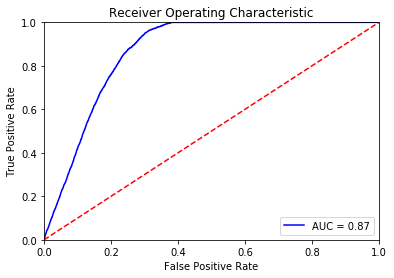

0.8238163643981564 
 [[ 0.08306519  0.12953876 -0.19254034 -0.36255022 -0.12548644  0.06061101
   0.07694645 -6.31435183  0.12864542  0.25823801  0.25837414  0.18385859
   0.267494    0.28754572 -0.02703206  0.25207909  0.2665039   0.08162709
  -0.07374177  0.40716545  0.36862088  0.42828288 -0.35330496 -1.34716657
  -1.45728939 -0.80120068  0.46465323 -0.02739205  0.19156357 -0.80181378
  -0.84977358 -0.86388115  2.28364809  2.27466619  2.30767289  2.3485917
   2.37534822 -5.25563143  0.         -0.86677621 -0.85984062 -0.84165877
   0.17358003  0.155802   -0.06501646  0.1166241   0.20957033  0.13836337
   0.01078039  0.36240174  0.36132945  0.01413432  0.03479802 -0.09586989
   0.22871967]]


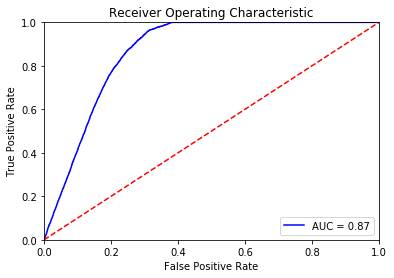

0.8256120189142275 
 [[ 0.07423554  0.03970891 -0.15088447 -0.12020049 -0.04989989  0.12350548
   0.06479402 -3.87370409  0.05945519  0.16899621  0.18246578  0.09448433
   0.22271522  0.21262864 -0.02891591  0.08675093  0.1834878  -0.03136244
   0.05922134  0.44497724  0.44584767  0.55703452 -0.21793405 -1.26503373
  -1.30180446 -0.790075    0.44402029  0.04761779  0.26692102 -0.64658618
  -0.57166704 -0.57016955  1.36150188  1.2920685   1.30915106  1.35659427
   1.24398576 -2.70487072  0.         -0.55391891 -0.55939585 -0.59234039
   0.03955572  0.12828916 -0.03560936  0.0570483   0.13852767  0.09821256
  -0.03411995  0.155013    0.10380598  0.00403091  0.0145446  -0.15533667
   0.22214363]]


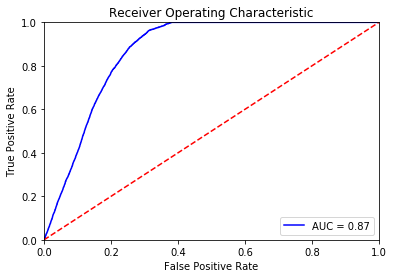

0.8292931106721734 
 [[ 0.12179589 -0.05614262 -0.10150922 -0.05395377  0.04710316 -0.05079406
  -0.00529281 -3.85699492  0.07600033  0.18132726  0.20617042  0.09582063
   0.23364669  0.23988294 -0.03138643  0.23906389  0.2345173   0.1363495
  -0.01160339  0.45821299  0.43795561  0.40415824 -0.32356904 -1.33639811
  -1.38908437 -0.86790828  0.4393172   0.10263031  0.28708505 -0.7382045
  -0.58305396 -0.5624722   1.32905521  1.31377589  1.28776673  1.34459955
   1.35268247 -2.77769755  0.         -0.5720448  -0.57327254 -0.58912841
  -0.06506837  0.01435226  0.02740119  0.06168131  0.06655427  0.03950812
   0.07497313  0.01926233  0.03899207  0.02108269 -0.04323299  0.01986977
   0.00756207]]


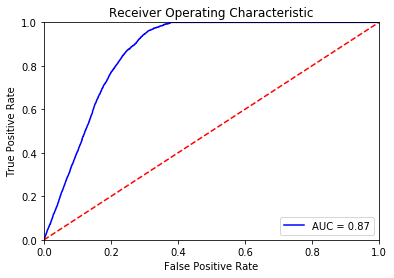

0.8225594062369067 
 [[ 3.26746599e-02  2.75370738e-02 -1.01633023e-01 -4.97726781e-02
  -5.44869080e-03 -3.47190407e-03 -3.04455512e-02 -3.84473448e+00
   1.40383060e-03  1.63097986e-01  1.16422752e-01 -1.40054819e-02
   1.20090374e-01  2.74407763e-01 -1.84709782e-02  7.58000503e-02
   6.28235115e-02 -5.91259189e-02 -1.07789042e-01  4.87138616e-01
   4.85127868e-01  5.33123311e-01 -2.20310836e-01 -1.22445108e+00
  -1.28402466e+00 -8.27612048e-01  5.03855697e-01  1.68195117e-01
   3.44190840e-01 -5.94235332e-01 -5.61654520e-01 -5.88349667e-01
   1.34621144e+00  1.29087490e+00  1.32503278e+00  1.27019455e+00
   1.31182448e+00 -2.70493499e+00  0.00000000e+00 -5.68817562e-01
  -5.50651448e-01 -5.81653708e-01 -7.95205426e-02 -5.25852467e-02
  -8.91883484e-02 -1.04944970e-01 -3.50957920e-02 -1.35832544e-01
   8.07867216e-02 -9.78926854e-02 -5.16096753e-02 -8.25782473e-02
  -5.40517841e-02 -9.35294079e-03  5.04344052e-02]]


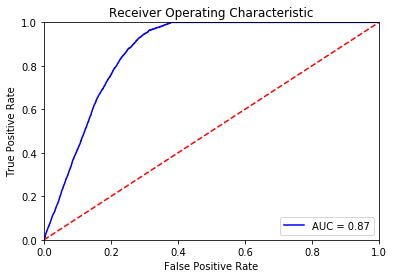

0.822709044113246 
 [[ 3.24145379e-02 -1.11149014e-01 -4.86758150e-02 -8.54324958e-02
  -2.15329838e-01  6.53866071e-02 -7.25229166e-03 -5.05324934e+00
   7.22518650e-02  2.75354006e-01  3.54057394e-01  1.71017499e-01
   2.58990013e-01  2.31253683e-01  7.32822822e-02  2.33199017e-01
   3.08195824e-01  1.40180680e-01  7.81841043e-02  3.22122135e-01
   3.72373564e-01  4.01668642e-01 -3.68702093e-01 -1.48521251e+00
  -1.38648031e+00 -9.19012943e-01  4.29540728e-01 -4.60117639e-04
   1.88659584e-01 -7.82012545e-01 -7.06698027e-01 -7.38607471e-01
   1.86047647e+00  1.77328390e+00  1.81198733e+00  1.81841512e+00
   1.79506543e+00 -4.01349897e+00  0.00000000e+00 -7.47502975e-01
  -7.31928587e-01 -7.24814531e-01  1.00391033e-01  3.18051026e-02
   3.90413490e-02  9.21579684e-02  3.55701217e-02  5.80280895e-02
   1.23410000e-01  4.04579643e-02 -3.16400526e-02  5.86621545e-02
  -9.21565460e-02  3.50250912e-02 -9.35686013e-03]]


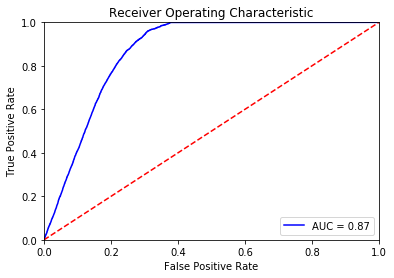

In [291]:
lrl2f16kcv5coef, lrl2f16kcv5score, lrl2f16kcv5pred = baglr(lr_l2,features1,16707,10)

In [292]:
np.mean(lrl2f16kcv5score)

0.8247530975040401

In [285]:
lrl2f16kcoef

{'ldistance': 0.08499853966233113,
 'ltemp': -0.07107922370890588,
 'clouds': -0.13046508152480152,
 'lpressure': -2.105940819870037,
 'rain': 0.03451914938655864,
 'lhumidity': 0.25023448774269613,
 'lwind': 0.009170166624538784,
 'cab_type_Uber': -9.73730146460982,
 'destination_Back Bay': 0.0971603359507872,
 'destination_Boston University': 1.1283736003278495,
 'destination_Fenway': 1.0400954588985083,
 'destination_Financial District': 0.12549479965126614,
 'destination_Haymarket Square': 1.176722471262884,
 'destination_North End': 0.9816556498045157,
 'destination_North Station': 0.05227167281417513,
 'destination_Northeastern University': 1.1330566638742834,
 'destination_South Station': 1.0539025063988672,
 'destination_Theatre District': 0.15373329600848376,
 'destination_West End': -0.001754993729175404,
 'source_Back Bay': 0.25594194440493095,
 'source_Boston University': 1.1311277187093114,
 'source_Fenway': 1.1887258833940086,
 'source_Financial District': -0.363450557150

In [289]:
np.mean(lrl2f16kscore)

0.8241036691207277

In [287]:
lrl2f16kpred

[array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0]),
 array([1, 0, 0, ..., 0, 0, 0])]

### The average score from the two specifications are very similar, and we chose L2.

In [360]:
lr_l2 = LogisticRegressionCV(penalty='l2', cv=5, solver='liblinear', n_jobs= -1)
mySample1 = Xy1.sample(16707, replace=True, random_state=i)
mySample = mySample1.append(Xy0.sample(16707, replace=True))
mySample.reset_index(inplace=True, drop=True)
y_sample = mySample['y']
x_sample = mySample[features]
lr_l2.fit(x_sample, y_sample)

KeyError: "['cab_type_Uber'] not in index"

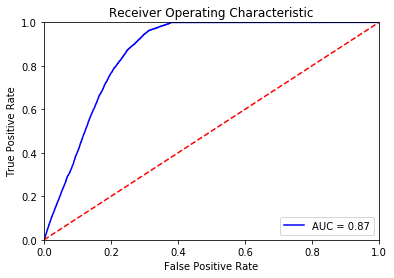

In [294]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_l2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [309]:
# This is a function to create the confusion matrix from our L2 model
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.68603913 0.31396087]
 [0.03686857 0.96313143]]
Confusion matrix, without normalization
[[84295 38577]
 [  154  4023]]


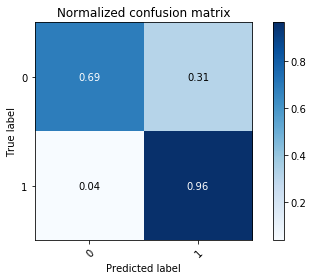

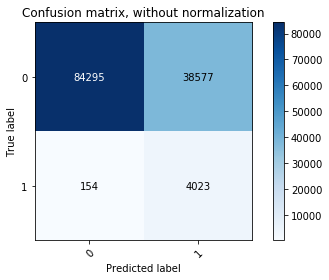

In [312]:
classnames = ['Surge', "Not Surge"]
preds2 = lr_l2.predict(X_test)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, preds2, classnames,
                      normalize=True)
plot_confusion_matrix(y_test, preds2, classnames)